# Introduction to LangGraph

LangGraph is a library from Langchain for building statful agents and multi-agent workflows. If you havent heard about what an agent is dont worry; we will describe what they are and what they do shortly.

LangGraph unlike other popular agent centric libraries like  "[Crew](https://www.crewai.com/)" and "[Autogen](https://microsoft.github.io/autogen/)", provides a fine-grained control over the flow and state of a LLM application by utilizing graph based approach to define the flow of the application.

LangGraph is shipped as a complete independent package and does not depend on Langchain package for its operation although it does integrate seamlessly with Langchain.


## Agents

Before we dive into developing an application with LangGraph , we first need to understand what an "Agent" is.

In our previous notebook "Langchain Tools", we have seen how a LLM which supports tool calling functionality can take in a list of tools and based on the user query , decides which of the available tools is most appropriate to answer the query. An agent is a extension to this tool calling functionality. 

Besides just returning the most appropriate tool to use, an agent takes an action and executes the selected tool with appropriate arguments. It then, processes the LLM response and determines if the response received answers the user query or it needs further evaluation or likely another tool to take the next step towards the final answer. An agent can run in this decision making loop until final answer to user query is acheived.


## How LangGraph Works
As mentioned earlier, LangGraph implements an agent or a multi-agent workflows using graphs. By definition, a Graph is a collection of vertices called "**Nodes**" and links called "**Edges**" that connect together pairs of nodes .At the heart of every graph lies the "**State**" of the graph which represents the current state of the application and is passed along between the Nodes at every step as the graph unfolds. In another words , the Nodes communicate with each other by reading and writing to this shared "State". 

Here's a basic low level flow of a LangGraph Application

<img src = "./images/LangGraph_flow.jpg" width="800" height="400">

Lets start by building a simple LangGraph application that will search the internet and find if there is a valid RFC document that exists based on the user query and then return the URL for that RFC document. We will make use of a predefined tool in Langchain called "**TavilySearchResults**" to help LLM find relevant information.

(**NOTE:** I will highly recommend going through **"Langchain Tools"** notebook first before continuing further in order to understand more about the tools and how to use them if you have not already done so. The remainder of this notebook assumes you are familier with tool calling and how langchain uses "bind_tools" function to invoke a tool.)

As we build our LangGraph , we will dive deeper into each of the above key constructs of "State", "Nodes" and "Edges"; but first lets do some prep work by installing and importing necesary packages, setting up our API keys , defining the tool which can search the internet and finally initializing our tool calling LLM model.

**Note**: 
* We are going to use Open AI's GPT-4-Tubo model for our use case by installing "langchain_openai" package. You can use any other model that you like. Langchain has packages for LLMs from different vendors.
* Since we are using an external tool "TavilySearchResults" , you will need an external python package "tavily-python" and also create an API key by visiting their website [here](https://tavily.com/)



In [6]:
%%capture --no-stderr
%pip install langgraph langsmith langchain_openai langchain_community tavily-python

# We are using Langsmith here for visibility and LLM response tracing
# but its not required for LangGraph

import os, getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass()
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
os.environ["TAVILY_API_KEY"] = getpass.getpass()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=2)
tools = [tavily_tool]

llm = ChatOpenAI(model="gpt-4-turbo")
llm_with_tools = llm.bind_tools(tools)

In [2]:
# TEST BLOCK
# Optional - testing for output from llm
# response = llm_with_tools.invoke("which RFC document describes RoCE technology?")
# tavily_tool.invoke("what is MPLS and where is it used?")
# if tools := response.tool_calls:
#     print(tools[0], type(tools))
# print(response)
# response.tool_calls

With all things setup and initialized , lets get started !!

### State
The very first thing we define when builing a langGraph application is the "State" class. Think of State as a container that will keep a track and update current state of all the things necessary to make a decision at every step of the graph. A decision could be requesting a LLM response based on the current state, or it could be asking LLM to decide which tool to use next based on the current state of the graph.


A State of the graph can be declared as any Python Data Structure but Langchain more commonly declares it as a "TypedDict" or a "Pydantic BaseModel". You should be familier with "Pydantic BaseModel" by now as we have used it a few times already in our previous notebook "**Langchain Tools**"

In [7]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

We define the State class of type "TypedDict" with a key "messages" of type list. We are also type hinting "messages"  with the type "Annotated". The annotation allows us to provide additional reference or information on the variable or object we are defining. In this case we are passing in a built in langgraph "**add_messages**" function which defines how the messages object should be updated.

Note that "add_messages" is a function that we are importing from "langgraph" library. Langchain calls these functions "Reducer Functions" whose sole purpose is to define how the updates should be applied to the current state. The "add_messages" function appends messages to the list rather than overwriting its contents as and when it gets updated. This is important as the State gets passed between different nodes as the graph unfolds,  it is important to keep a reference of all the past messages in the State instead of just the most recent or last message.

One thing to note here is that we have only one key ("messages") defined in our State. However depending on your application , and the things you need to keep track of during the entire lifecycle of the graph, you may need more keys defined in your State accordingly.

we will get back to "graph_builder" object later in this notebook when we actually compile and run the graph. For now , just make a note that we are passing our newly defined "State" class as a parameter to "Stategraph" class that is imported again from "langgraph".

Okay, the State of th graph is now defined. As you will see, this state will be initialized when the graph is started and then passed along different nodes during the lifecycle of the graph until completion.

### Nodes
Nodes are just simple Python functions that you will define to interact with the LLM. These functions will typically include your "**llm.invoke**" methods to get responses from the LLM. At a very basic level they take in current state of the graph as input; interact with LLM based on that current state ; and update the state with the response it receives from LLM.

When a node returns and updates the State, the list object "messages" that we defined in the "State" class will be updated.

Although Langchain does not explicitly define it, but looking at multiple examples of LangGraph executions, we can generalize and categorize these nodes under 4 types:

* Agent Node
* Tool Node
* START Node
* END Node

#### Agent Node
Agent Nodes interact with LLM using "invoke" method by providing a prompt and an optional list of available tools. If your application uses tools which is a more likely scenario, then Langchain strongly recommends using a LLM model that supports tool calling functionality.

The main purpose behind an Agent node is to prompt a LLM based on the current state of the graph and receive necessary information that decides next steps a graph should take. What next steps a graph takes depends on whether the response includes any tool information or not. If LLM decides it needs to call one of the available tools as a next step, it will include the tool name along with all the arguments that are required to call that tool. We will see this information under "**tool_calls**" object in the response from LLM.

Here's a basic schema for a "tool_calls" object

``` 
tool_calls=[
        {
        'name': 'tavily_search_results_json', 
        'args': {'query': 'current weather in San Francisco'}, 
        'id': 'call_ijG8ny0FU3saCvWLasQanZRY', 
        'type': 'tool_call'
    }
]
```
It is important to pay attention here that an agent node does not call a tool, it only provides necessary information to call a tool. We will see this as we progress that it is the "**Tool Node**" that uses the "tool_calls" object to call and execute the tool.

Lets define a Agent Node for our "RFC Finder" app that takes in the State as input and invokes LLM for a response based on the information in the list state["messages"]. Keep in mind that the LLM we are using here is already equipped with the list of tools using "bind_tools" funtion that we already declared earlier. Once we define our Agent node, we add it to our graph using "add_node()" method of "graph_builder" object.

**Note**: You can check [here]("https://python.langchain.com/v0.2/docs/integrations/chat/?ref=blog.langchain.dev") for a list of models that supports tool calling functionality.

In [8]:
def agent_node(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("agent_node", agent_node)

#### Tool Node
A Tool Node is very similar to an Agent Node in that its just another python function that you define prompting a response from LLM. The difference however is that a tool node actually calls the tool using information from the most recent "tool_calls" object under "State["messages"].

At a very basic level,  a Tool Node will include "**tool_call["name"].invoke(tool_call["args"])**" method call. If we want , we can define this function ourselves; but Langchain has already done this prepwork for us and  implemented this functionality  by providing a "ToolNode" builtin class.

Since we have already defined our tool "**tavily_tool**" earlier, we are going to provide this tool as an agrument to instantiate "ToolNode" class. Finally, just like we added our Agent node to the graph, we will also add our Tool node to the graph using "add_node" method under "graph_builder" object.

In [9]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tool_node", tool_node)

#### Start Node

A Start node is a Node which bears a special significance.  Unlike an Agent node, a Start node holds a initial user or system prompt rather than the current state of the graph. As you have already learnt, an Agent node needs some kind of a state to act upon; and at the very start of the graph that state is empty. It is a Start node that populates the initial state of our graph with user/system prompt. In other words , we can say that a Start node is simply a reference point for our graph to get its initial state.

We dont have to implement any functionality for a Start node like we did when defining our Agent node. We can simply import "START" node from langgraph's graph module. The part that we need to do, is to tell the Start node which node to call first in order to instantiate our graph. We do that using "add_edge" method of "graph_builder" object. I know we havent discussed about "edges" yet, so dont worry about what "add_edge" method does. It will become more clear once we learn about the edges.

In [10]:
from langgraph.graph import START

graph_builder.add_edge(START, "agent_node")

#### End Node
Well you guessed it, just like we need a node to start a graph, we also need one to end it. An "End" node when called upon tells our graph to exit. we reference an End node in our application when the LLM response from Agent node does not contain any further actions to take or tools to call. At this point we generally have a final answer to user's initial prompt and our graph needs a reference point to exit gracefully.

In [11]:
from langgraph.graph import END

graph_builder.add_edge("agent_node", END)

#### Edges

If you are coming from a background in computer science, you may already be aware of what "Edges" are in a graph. In essence and in context of LangGraph, edges are the links that connect our nodes. they direct the logic of our graph from one node to another. 

Lets say an Agent node receives a LLM response that contains information about the tool that needs to be called. We have already seen that an Agent node by itself does not act upon and call the tool, it simply updates the current state of the graph with the information it received from LLM. We need some kind of a dependency and logic in our graph to pass control to the Tool Node so that the proposed tool can be called. This is where Edges come into play. Edges provide a way to pass control of the graph from one node to another.

As Langchain puts it "**nodes do the work. edges tell what to do next**"

Edges are an important part of the overall flow of your application and how different nodes communicate with each other. There are a few types of edges that we need to know about.

##### Normal Edges
These are simple edges that pass the control from one node to another. We have already seen these types of edges when defining our Start and End nodes in the previous section. Let's take our Start node example and take a more closer look here.

```graph_builder.add_edge(START, "agent_node")```

Here we are adding a normal edge , that tells the graph to pass the control from start node to our Agent node. With the current state populated with initial user/system prompt by Start node, Agent node can now act upon that initial state and continue with its operations.


##### Conditional Edges

We have now seen that Edges allow us to pass on the state of the graph from one node to another with "Normal Edges" being the simplest where both "From" and "To" nodes are already known to us. What if your application needs to wait on the LLM response to decide which node to go next?. This condition is not uncommon. As we have discussed this a few times already, the response from an Agent node may contain tool information if LLM decides tool execution as the next step; or it may just have the final answer and the application needs to call an End node. As you can see, there some decision making thats involved here and based on the response we receive from Agent node, we "Route" the graph execution to the next node accordingly. This is the function of a "Conditional Edge"

We define a conditional edge using "add_conditional_edge" method of graph_builder object. However, this method by itself does not perform the decision making function, it depends on a routing function that is passed as an argument  along with the node whose response will decide the routing function's decision on which node to execute next.

``` graph_builder.add_conditional_edges("node", routing_function)```


If it helps you to understand better, think of routing function as just another node. It shares a lot of similarity with the nodes that we have already learnt. First, it is python function just like any other node which takes in current state of the graph as input and returns some output. Second, we provide it as a argument when creating edges just like we add edges between any two nodes.

The difference however lies in response that routing function provides compared to nodes. A node returns response from LLM call. The routing function returns name of the next node to receive state of the graph and continue execution.

With the Edges explained , lets define a routing function and a conditional edge for our application. The routing function will return either a Tool node or an End node depending on the response the routing function receives from Agent node. At a very high level , our routing function will look "tool_calls" in the Agent nodes response. If present, it will return "tool_node" else "END" node.


In [12]:
def routing_function(state:State):
    most_recent_state = state.get("messages")[-1]
    if most_recent_state.tool_calls:
        return "tools"
    else:
        return "END"

graph_builder.add_conditional_edges("agent_node", routing_function)

Okay, so far so good. We have now handled the scenario where every time an Agent node is called, the routing function will decide which node to go next. So then, what do we do every time a Tools node is called? Do we need an edge that defines which node to go next ?. The answer is Yes. We need to decide which node will be called after Tools node returns with a response from LLM.

The good thing is we dont have to make any routing decision in this case. Think about it for a second. A tool node calls a tool and and the result gets updated to the state of our graph. What do we do with the update state on deciding the next action? Simple, we ask LLM what to do next. So we go back to the Agent node. Thus defining a normal edge would suffice in this case. Lets go ahead and do that

In [13]:
graph_builder.add_edge("tool_node", "agent_node")

#### Compile and Run

Congratulations!!, you have now successfully built a very simple yet powerful LLM Agent using LangGraph framework. The final action that remains is compiling and running the graph. 

we compile by invoking the "compile" method on graph_builder object. with "compile" method, Langchain does some basic checks in the backend making sure the overall structure and the schema of the graph is maintained. You can also provide some additional arguments to the compile method , but we will not go into that to keep things simple here.

In [14]:
graph = graph_builder.compile()

Lets just briefly summarize what we have done so far. To build a graph, we first define the state, we then add nodes and edges, and then we compile it. We cannot run a graph without compiling it first.

If we were to visualize the overall flow of our agent application , this is how it would look.
Run the code cell below to print the flow diagram of our graph.

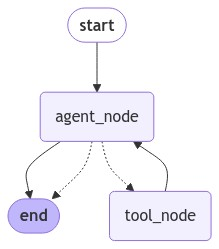

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


Let's go ahead,  ask some questions to our graph and run our agent application.

In [36]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import ChatPromptTemplate

#response = graph.invoke({"messages": [HumanMessage(content="what is segment routing in networking?")]})
#OR
system_prompt = """
You are a researcher in the field of computer networking and has extensive experience in writing RFC documents for various networking protocols and technologies. Given a technical user question related to computer networking field,\
your job is to identify which RFC document on the internet would be most relevent in answering user query.

Follow the instructions closely.
1. Do not provide any detail explanation of the answer related to user query. 
2. your answer should strictly provide only the RFC document number and name along with the URL link to access the RFC document.
3. you can respond with more than one relevent RFC documents if you think multiple documents are necessary to answer user's question.
3. If you don't know the answer, just say that you could not find the relevent RFC document that answers users query. Do not try to guess the answer or make up the answer

You are given a list of following tools at your disposal. Use tools when appropriate.
tools: {list_of_tools}
"""

user_prompt = "{user_input}"

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", user_prompt)
])

initial_input_to_graph = prompt.format_messages(list_of_tools=tools, user_input="I want to learn about RoCE RDMA over converged Ethernet protocol")

graph_output = graph.invoke({"messages": initial_input_to_graph})



Skipping write for channel 'branch:agent_node:routing_function:tools' which has no readers


In [37]:
graph_output.get("messages")[-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UIT0DePCz1MYGnMPU3WE93fp', 'function': {'arguments': '{"query":"RoCE RDMA over Converged Ethernet protocol RFC"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 296, 'total_tokens': 324, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_68a5bb159e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf5c27f4-d01f-4db4-a5ff-52c469f3d4f6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'RoCE RDMA over Converged Ethernet protocol RFC'}, 'id': 'call_UIT0DePCz1MYGnMPU3WE93fp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 296, 'output_tokens': 28, 'total_tokens': 324})